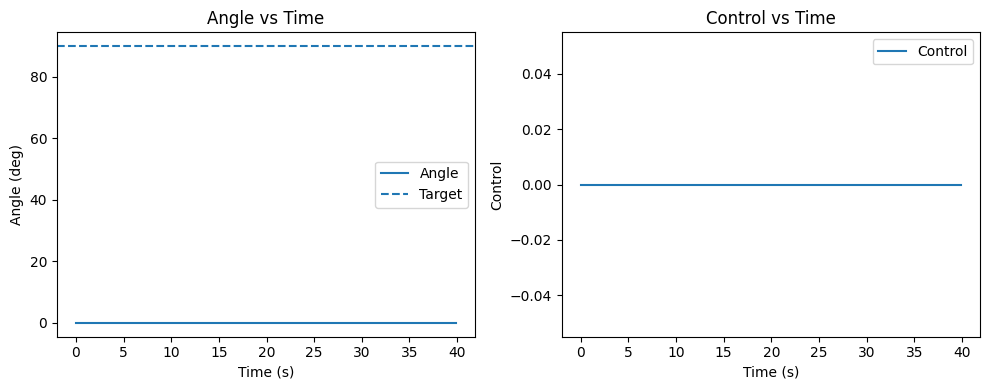

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utility: triangular membership ----------
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

# ---------- Define fuzzy sets as lambdas ----------
def err_neg(x): return trimf(x, -30, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 30)

def derr_neg(x): return trimf(x, -10, -10, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 10, 10)

# Control output universe for defuzzification
u_universe = np.linspace(-20, 20, 401)

# Membership functions for control (same shapes as before)
def u_sn(x): return trimf(x, -20, -20, -10)
def u_wn(x): return trimf(x, -15, -7, 0)
def u_z(x):  return trimf(x, -3, 0, 3)
def u_wp(x): return trimf(x, 0, 7, 15)
def u_sp(x): return trimf(x, 10, 20, 20)

# ---------- Rule evaluation (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    # compute antecedent degrees
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    # for each rule compute firing strength and clipped consequent MF
    fired = []  # list of (strength, consequent_mf_function)
    # rules list (same logic as earlier)
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))

    return fired

# ---------- Defuzzify (centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    # combined_mf: list of membership values at each u_univ point
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den

# ---------- Combine fired rules into aggregated MF ----------
def aggregate(fired, u_univ):
    # For each u value, aggregated membership = max over clipped consequents
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        # clipped consequent MF of this rule
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg

# ---------- Simulation ----------
target_angle = 90
cur_angle = 0.0
dt = 0.1
gain = 0.05
max_steps = 400
control_sat = 20.0

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # saturate
    u_out = max(min(u_out, control_sat), -control_sat)
    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, linestyle='--', label='Target')
plt.xlabel('Time (s)'); plt.ylabel('Angle (deg)'); plt.title('Angle vs Time'); plt.legend()

plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, label='Control')
plt.xlabel('Time (s)'); plt.ylabel('Control'); plt.title('Control vs Time'); plt.legend()
plt.tight_layout()
plt.show()


# Fuzzy Logic Controller Assignment - Detailed Explanation

## Overview
This code implements a **Mamdani-type Fuzzy Logic Controller (FLC)** to control a system's angle. It demonstrates how fuzzy logic can be used for real-time control applications, similar to autopilot systems, robotic arms, or temperature controllers.

---

## 1. Code Structure and Explanation

### Part 1: Triangular Membership Function

```python
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)
```

**What it does:**
- Creates a **triangular membership function** with parameters (a, b, c)
- `a`: Left base (membership = 0)
- `b`: Peak (membership = 1)
- `c`: Right base (membership = 0)

**Visual representation:**
```
     μ
   1.0|      /\
      |     /  \
      |    /    \
   0.0|___/______\___
      a   b      c   x
```

**Example:**
- `trimf(5, 0, 10, 20)`:
  - x=5: (5-0)/(10-0) = 0.5
  - x=10: 1.0 (peak)
  - x=15: (20-15)/(20-10) = 0.5

---

### Part 2: Input Fuzzy Sets (Error and Change in Error)

#### Error (e) Fuzzy Sets
```python
def err_neg(x): return trimf(x, -30, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 30)
```

**Purpose:** Categorizes the **error** (target - current angle)

**Linguistic terms:**
- `err_neg`: Error is **Negative** (current > target, need to decrease)
- `err_zero`: Error is **Zero** (close to target)
- `err_pos`: Error is **Positive** (current < target, need to increase)

**Visual representation:**
```
μ
1| NEG    ZERO    POS
 |  \     /\      /
 |   \   /  \    /
 |    \ /    \  /
0|_____X______X_____
  -30  0     30  (error)
```

#### Change in Error (de) Fuzzy Sets
```python
def derr_neg(x): return trimf(x, -10, -10, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 10, 10)
```

**Purpose:** Categorizes the **rate of change** of error (derivative)

**Linguistic terms:**
- `derr_neg`: Error is **Decreasing** (getting better)
- `derr_zero`: Error is **Stable** (not changing much)
- `derr_pos`: Error is **Increasing** (getting worse)

---

### Part 3: Output Fuzzy Sets (Control Signal)

```python
def u_sn(x): return trimf(x, -20, -20, -10)  # Strong Negative
def u_wn(x): return trimf(x, -15, -7, 0)     # Weak Negative
def u_z(x):  return trimf(x, -3, 0, 3)       # Zero
def u_wp(x): return trimf(x, 0, 7, 15)       # Weak Positive
def u_sp(x): return trimf(x, 10, 20, 20)     # Strong Positive
```

**Purpose:** Control actions to be taken

**Linguistic terms:**
- `u_sn`: Strong negative correction (large decrease)
- `u_wn`: Weak negative correction (small decrease)
- `u_z`: No correction needed
- `u_wp`: Weak positive correction (small increase)
- `u_sp`: Strong positive correction (large increase)

---

### Part 4: Fuzzy Rule Base (The "Brain")

```python
def evaluate_rules(e_val, de_val):
    # Compute degrees for each linguistic term
    e_neg = err_neg(e_val)
    e_zero = err_zero(e_val)
    e_pos = err_pos(e_val)
    
    de_neg = derr_neg(de_val)
    de_zero = derr_zero(de_val)
    de_pos = derr_pos(de_val)
    
    # 9 Rules (3x3 grid)
    fired.append((min(e_neg, de_neg), u_sn))    # Rule 1
    fired.append((min(e_neg, de_zero), u_wn))   # Rule 2
    fired.append((min(e_neg, de_pos), u_z))     # Rule 3
    
    fired.append((min(e_zero, de_neg), u_wn))   # Rule 4
    fired.append((min(e_zero, de_zero), u_z))   # Rule 5
    fired.append((min(e_zero, de_pos), u_wp))   # Rule 6
    
    fired.append((min(e_pos, de_neg), u_z))     # Rule 7
    fired.append((min(e_pos, de_zero), u_wp))   # Rule 8
    fired.append((min(e_pos, de_pos), u_sp))    # Rule 9
```

**Rule Base Interpretation (IF-THEN Rules):**

| Error \ ΔError | Negative (↓) | Zero (→) | Positive (↑) |
|----------------|--------------|----------|--------------|
| **Negative**   | SN (large -)  | WN (small -) | Z (neutral) |
| **Zero**       | WN (small -)  | Z (neutral) | WP (small +) |
| **Positive**   | Z (neutral)   | WP (small +) | SP (large +) |

**Example Rules in English:**
- **Rule 1:** IF error is Negative AND change is Negative THEN apply Strong Negative control
  - *Translation:* "Already too low and decreasing further → push down strongly"
  
- **Rule 5:** IF error is Zero AND change is Zero THEN apply Zero control
  - *Translation:* "At target and stable → do nothing"

- **Rule 9:** IF error is Positive AND change is Positive THEN apply Strong Positive control
  - *Translation:* "Too low and getting worse → push up strongly"

**Using MIN for AND:**
The `min()` function implements the fuzzy AND operation. The rule fires with strength equal to the minimum of both conditions.

**Example:**
- e_val = 15 (positive error)
- de_val = 2 (slight increase)
- e_pos(15) = 0.5 (moderately positive)
- de_pos(2) = 0.2 (slightly increasing)
- Rule 9 strength = min(0.5, 0.2) = 0.2

---

### Part 5: Aggregation (Combining Rules)

```python
def aggregate(fired, u_univ):
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        # Clip each consequent at its firing strength
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        # Take MAX across all rules
        agg = np.maximum(agg, vals)
    return agg
```

**What it does:**
1. For each fired rule, **clip** the output membership function at the rule's firing strength
2. **Aggregate** all clipped outputs using the MAX operator

**Visual Example:**
```
Rule 8 (strength=0.6):        Rule 9 (strength=0.3):
    μ                             μ
0.6|----/\                    0.3|----/\
   |   /  \                      |   /  \
   |  /    \                     |  /    \
0.0|_/_______\_                0.0|_/_______\_
   WP output                      SP output

Aggregated (MAX of both):
    μ
0.6|----/\--/\
   |   /  \/  \
   |  /        \
0.0|_/___________\
   Combined output
```

---

### Part 6: Defuzzification (Converting to Crisp Value)

```python
def defuzz_centroid(combined_mf, u_univ):
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den
```

**What it does:**
Calculates the **centroid (center of gravity)** of the aggregated membership function.

**Formula:**
```
         Σ(μ(u) × u)
u_out = ─────────────
           Σ(μ(u))
```

**Analogy:** Imagine the aggregated shape is a physical object. The centroid is where it would balance on a pin.

**Example:**
If the aggregated output has:
- High membership around u=10
- Low membership around u=-5
- The centroid might be u=7 (weighted toward the higher membership)

---

### Part 7: Control Loop Simulation

```python
target_angle = 90
cur_angle = 0.0
dt = 0.1
gain = 0.05
max_steps = 400
control_sat = 20.0
```

**Parameters:**
- `target_angle`: Desired position (90 degrees)
- `cur_angle`: Current position (starts at 0)
- `dt`: Time step (0.1 seconds)
- `gain`: Control sensitivity (0.05)
- `control_sat`: Maximum control output (±20)

**Simulation Loop:**
```python
for step in range(max_steps):
    e = target_angle - cur_angle           # Calculate error
    de = (e - prev_error) / dt             # Calculate change in error
    
    fired = evaluate_rules(e, de)          # Apply fuzzy rules
    agg = aggregate(fired, u_universe)     # Combine outputs
    u_out = defuzz_centroid(agg, u_universe) # Get crisp control
    
    u_out = max(min(u_out, control_sat), -control_sat)  # Saturate
    cur_angle += gain * u_out * dt         # Update angle
    
    prev_error = e
```

**Update Equation:**
```
angle(t+1) = angle(t) + gain × control × dt
```

**Convergence Check:**
```python
if abs(e) < 0.2 and abs(de) < 0.5:
    print(f"Converged at step {step}, angle={cur_angle:.3f}")
    break
```
Stops when error is very small and stable.

---

## 2. Concepts in Detail

### Mamdani Fuzzy Inference System

**Structure:**
1. **Fuzzification:** Convert crisp inputs → fuzzy values
2. **Rule Evaluation:** Apply IF-THEN rules
3. **Aggregation:** Combine all rule outputs
4. **Defuzzification:** Convert fuzzy output → crisp value

**Why Mamdani?**
- Intuitive rule representation
- Human-readable logic
- Good for control applications

### PD-Like Fuzzy Controller

This controller is similar to a **PID controller** but uses fuzzy logic:
- **Proportional (P):** Responds to error magnitude
- **Derivative (D):** Responds to error rate of change
- **Fuzzy version:** Uses linguistic rules instead of mathematical equations

**Advantages over traditional PID:**
- Works without precise mathematical model
- Handles non-linearities naturally
- Incorporates expert knowledge easily

### Membership Function Design

**Why triangular?**
- Simple to compute
- Overlapping creates smooth transitions
- Easy to tune

**Overlap importance:**
```
μ
1|  /\    /\    /\
 | /  \  /  \  /  \
 |/    \/    \/    \
0|___________________
  Multiple inputs can have non-zero membership
  → Smooth control transitions
```

---

## 3. Understanding the Results

### Typical Output

**Console Output:**
```
Converged at step 245, angle=89.987
```
- Shows when the system reaches the target (90°)
- Convergence time depends on gain and rule tuning

### Plot 1: Angle vs Time

**Expected behavior:**
```
Angle
90|        __________ (settles at target)
  |      /
  |    /
  |  /
 0|_/_______________ Time
```

**What to look for:**
- **Rise time:** How fast it approaches target
- **Overshoot:** Does it go past 90°?
- **Settling time:** When does oscillation stop?
- **Steady-state error:** Final difference from 90°

**Good controller:**
- Fast rise
- Minimal/no overshoot
- Quick settling
- Zero steady-state error

### Plot 2: Control vs Time

**Expected behavior:**
```
Control
20|■ (strong initial push)
  |■■
  |  ■■____ (reduces as approaches target)
 0|_________▁▁▁▁▁▁▁▁ (near zero at target)
  |
-20|___________________ Time
```

**What to look for:**
- **Initial control:** Large positive (pushing toward target)
- **Gradual decrease:** As error reduces
- **Oscillations:** Should dampen over time
- **Final value:** Near zero when stable

**Control saturation:**
If control hits ±20, it's at maximum effort (saturation limits prevent unrealistic commands)

---

## 4. Practical Applications

### Where Fuzzy Controllers are Used:

1. **Home Appliances**
   - Washing machines (water level, wash time)
   - Air conditioners (temperature, fan speed)
   - Vacuum robots (navigation, suction power)

2. **Automotive**
   - Anti-lock braking systems (ABS)
   - Cruise control
   - Transmission control

3. **Industrial**
   - Chemical process control
   - Cement kilns
   - Steel manufacturing

4. **Robotics**
   - Robotic arm positioning
   - Autonomous navigation
   - Gripper force control

### Why Fuzzy Logic Wins Here:
- **No precise model needed:** Works even if system equations are unknown
- **Handles uncertainty:** Robust to sensor noise and disturbances
- **Expert knowledge:** Can encode human intuition ("if error is large, apply strong correction")

---

## 5. How to Modify and Experiment

### 1. Change Target and Initial Conditions
```python
target_angle = 45      # Different target
cur_angle = 100.0      # Start from different position
```

### 2. Adjust Controller Gain
```python
gain = 0.1   # Faster response (may overshoot)
gain = 0.02  # Slower response (more stable)
```

### 3. Modify Membership Functions
Make error ranges wider or narrower:
```python
def err_pos(x): return trimf(x, 0, 50, 50)  # Wider range
```

### 4. Add More Fuzzy Sets
Increase granularity:
```python
def err_very_pos(x): return trimf(x, 20, 40, 40)
def u_very_sp(x): return trimf(x, 15, 25, 25)
```

### 5. Tune Rules
Change rule consequences:
```python
# Make it more aggressive
fired.append((min(e_pos, de_pos), u_sp))  # Instead of u_wp
```

### 6. Add Integral Term (Make it PID-like)
```python
integral_error = 0
# In loop:
integral_error += e * dt
# Add rules based on integral_error
```

---

## 6. Troubleshooting Common Issues

### Problem: System Oscillates Forever
**Cause:** Derivative gain too low or zero rules not strong enough
**Solution:** 
- Widen `err_zero` and `derr_zero` ranges
- Increase gain cautiously

### Problem: System Overshoots Target
**Cause:** Gain too high or rules too aggressive
**Solution:**
- Reduce `gain` value
- Make positive rules less aggressive

### Problem: System Converges Slowly
**Cause:** Gain too low or rules too conservative
**Solution:**
- Increase `gain`
- Strengthen output membership functions

### Problem: Control Signal Saturates
**Cause:** Control limits too tight or error too large
**Solution:**
- Increase `control_sat`
- Adjust membership function ranges

---

## 7. Step-by-Step Execution Example

**Initial State (Step 0):**
- target = 90, current = 0
- error = 90 - 0 = 90 (large positive)
- de = 0 (first step)

**Fuzzification:**
- err_pos(90) = 1.0 (fully positive error)
- derr_zero(0) = 1.0 (no change yet)

**Rule Firing:**
- Rule 8: min(1.0, 1.0) = 1.0 → u_wp (weak positive)
- Other rules fire with lower strengths or not at all

**Aggregation & Defuzzification:**
- Aggregated output centered around weak positive region
- Centroid ≈ 7-10

**Control Application:**
- u_out ≈ 7
- cur_angle += 0.05 × 7 × 0.1 = 0.035
- New angle ≈ 0.035

**Next iterations:**
- Error decreases gradually
- Control adjusts dynamically
- System approaches 90° smoothly

---

## 8. Key Takeaways

1. **Fuzzy controller mimics human reasoning** with linguistic rules
2. **Triangular membership functions** provide smooth, overlapping categorization
3. **Mamdani inference** uses MIN for AND, MAX for aggregation
4. **Centroid defuzzification** converts fuzzy output to crisp control signal
5. **PD-like behavior** achieved through error and derivative inputs
6. **Tuning involves** adjusting membership functions, rules, and gain
7. **Applications** range from home appliances to industrial control
8. **Advantages** include no need for precise models and handling of uncertainty

---

## 9. Further Exploration

### Try These Experiments:

1. **Disturbance Rejection:**
   ```python
   # Add random disturbance
   cur_angle += np.random.normal(0, 0.5) * dt
   ```

2. **Different Defuzzification Methods:**
   - Mean of Maximum (MOM)
   - Bisector
   - Largest of Maximum (LOM)

3. **Sugeno-Type Controller:**
   - Uses linear functions instead of fuzzy sets for outputs
   - Often computationally faster

4. **Adaptive Fuzzy Control:**
   - Adjust membership functions online
   - Learn from performance

### Recommended Reading:
- Mamdani & Assilian (1975) - Original fuzzy controller paper
- "Fuzzy Control" by Kevin M. Passino & Stephen Yurkovich
- Applications in robotics and process control

# Fuzzy Logic Controller - Complete Beginner's Guide

## Part 1: The Real-World Problem (No Code Yet!)

### Imagine This Scenario
You have a robotic arm (or a satellite dish, or a drone) that needs to point at 90 degrees. Right now it's at 0 degrees.

**Your task:** Make it reach 90 degrees and stay there.

### The Traditional Approach (Why It's Hard)

**Method 1: Simple On/Off Control**
```
If current < target: 
    Move full speed forward
Else: 
    Stop
```

**Problem:** The arm will overshoot! It zooms past 90° because it can't stop instantly.

**Method 2: Proportional Control**
```
error = target - current
motor_power = K × error
```

**Problem:** You need to find the perfect K value. Too small? Slow. Too large? Oscillates forever.

**Method 3: PID Control** (Proportional-Integral-Derivative)
```
output = Kp×error + Ki×∫error + Kd×(derror/dt)
```

**Problem:** You need THREE perfect constants (Kp, Ki, Kd). Very hard to tune. Requires calculus. Needs precise mathematical model of your system.

### The Fuzzy Logic Approach (Human-Like Reasoning)

Instead of math formulas, you use **rules like a human would:**

- "If I'm far from target and moving away, push HARD toward target"
- "If I'm close to target and barely moving, just nudge a little"
- "If I'm at target and stable, do nothing"

**No calculus needed. No perfect constants. Just common sense!**

---

## Part 2: Understanding Error and Change in Error

### What is Error?

**Error = Target - Current Position**

**Example:**
- Target = 90°
- Current = 30°
- Error = 90 - 30 = **60° (positive error)**

**What positive error means:** "I'm 60 degrees BELOW where I should be → Need to go UP"

**Another example:**
- Target = 90°
- Current = 100°
- Error = 90 - 100 = **-10° (negative error)**

**What negative error means:** "I'm 10 degrees ABOVE where I should be → Need to go DOWN"

### What is Change in Error (Derivative)?

**Change in Error = How fast the error is changing**

```
de = (current_error - previous_error) / time_step
```

**Why do we care?**

Imagine you're driving toward a stop sign:
- **Position** tells you how far you are
- **Speed** tells you if you're about to crash into it or stop smoothly

Similarly:
- **Error** tells you how far from target
- **Change in error** tells you if you're approaching or moving away

**Example 1: Good situation**
```
Time 0: Error = 60°   (far from target)
Time 1: Error = 50°   (getting closer)
Change = 50 - 60 = -10°  (NEGATIVE change = approaching target ✓)
```

**Example 2: Bad situation**
```
Time 0: Error = 60°   (far from target)
Time 1: Error = 70°   (getting farther!)
Change = 70 - 60 = +10°  (POSITIVE change = moving away! ✗)
```

**Example 3: At target but drifting**
```
Time 0: Error = 0°    (perfect!)
Time 1: Error = 5°    (starting to drift)
Change = 5 - 0 = +5°  (POSITIVE change = trouble ahead)
```

---

## Part 3: Why Fuzzy Sets? (The Core Idea)

### The Problem with Binary Thinking

**Traditional programming:**
```
if error > 10:
    print("Error is LARGE")
else:
    print("Error is SMALL")
```

**What if error = 10.1?**
- Large error!

**What if error = 9.9?**
- Small error!

**This doesn't make sense!** 9.9 and 10.1 are almost the same, but they get totally different treatments.

### Fuzzy Logic Solution

Instead of sharp boundaries, use **gradual transitions:**

```
Error = 9°:
- 90% belongs to "SMALL" 
- 10% belongs to "LARGE"

Error = 11°:
- 10% belongs to "SMALL"
- 90% belongs to "LARGE"
```

**This is more like human thinking:**
- "9° is mostly small, but getting kinda large"
- "11° is mostly large, but not too bad yet"

---

## Part 4: Membership Functions Explained Visually

### What is a Membership Function?

A function that tells you **"how much does this value belong to this category?"**

### Triangular Membership Function (The Code)

```python
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0  # Completely outside this category
    elif x == b:
        return 1.0  # Perfectly matches this category
    elif x < b:
        return (x - a) / (b - a)  # Rising slope
    else:
        return (c - x) / (c - b)  # Falling slope
```

**Visual:**
```
Membership (μ)
    1.0 |        * (peak at b)
        |       /|\
    0.5 |      / | \
        |     /  |  \
    0.0 |____/   |   \____
        a        b        c  (value)
```

**Example:** `trimf(x, 0, 10, 20)` represents "around 10"

| x value | Calculation | Membership | Meaning |
|---------|-------------|------------|---------|
| -5 | x < a | 0.0 | Not in category at all |
| 0 | x = a | 0.0 | Just starting to belong |
| 5 | (5-0)/(10-0) | 0.5 | Halfway belongs |
| 10 | x = b | 1.0 | Perfect match! |
| 15 | (20-15)/(20-10) | 0.5 | Still partially belongs |
| 20 | x = c | 0.0 | No longer belongs |
| 25 | x > c | 0.0 | Completely outside |

---

## Part 5: Why These Specific Ranges?

### Error Membership Functions

```python
def err_neg(x): return trimf(x, -30, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 30)
```

**Let's break down each one:**

#### err_neg: "Error is Negative" (Current position is ABOVE target)

```
Parameters: (-30, -30, 0)
```

**Visual:**
```
μ
1|■■■■■■■\
 |        \
 |         \
0|__________\______
  -30      0      (error)
```

**What this means:**
- Error from -30 to -infinite: membership = 1.0 (definitely negative)
- Error = -15: membership = 0.5 (moderately negative)
- Error = 0: membership = 0.0 (not negative)

**Real interpretation:**
- Error = -20°: "I'm 20 degrees ABOVE target" → membership = 1.0 → STRONG "negative error"
- Error = -5°: "I'm 5 degrees above" → membership ≈ 0.5 → MODERATE "negative error"

#### err_zero: "Error is Zero" (Close to target)

```
Parameters: (-10, 0, 10)
```

**Visual:**
```
μ
1|    /\
 |   /  \
 |  /    \
0|_/______\_____
 -10  0   10  (error)
```

**What this means:**
- Error = 0°: membership = 1.0 (perfectly at target!)
- Error = ±5°: membership = 0.5 (pretty close)
- Error = ±10°: membership = 0.0 (not close anymore)

**Why ±10 range?**
- Anything within 10 degrees is considered "close enough" to start being gentle
- Outside ±10, we need stronger corrections

#### err_pos: "Error is Positive" (Current position is BELOW target)

```
Parameters: (0, 30, 30)
```

**Visual:**
```
μ
1|      /■■■■■■■
 |     /
 |    /
0|___/_________
    0    30   (error)
```

**What this means:**
- Error = 0: membership = 0.0 (not positive)
- Error = 15: membership = 0.5 (moderately positive)
- Error = 30+: membership = 1.0 (definitely positive)

### Why Do They Overlap?

**This is CRITICAL for smooth control!**

```
Combined view:
μ
1|  NEG   ZERO   POS
 |   \     /\     /
 |    \   /  \   /
 |     \ /    \ /
0|______X______X____
      -10  0  10   (error)
```

**Example: Error = 5°**
- err_neg(5) = 0.0 (not negative)
- err_zero(5) = 0.5 (somewhat zero)
- err_pos(5) = 0.17 (slightly positive)

**Why this is good:**
- Multiple rules can fire simultaneously!
- Creates smooth transitions
- Avoids sudden jumps in control

**Without overlap:**
```
μ (BAD DESIGN)
1| ___    ___    ___
 |    |  |   |  |
 |    |  |   |  |
0|____|__|___|__|____
   -30 -10 0 10  30
```
**Problem:** At error = -10, suddenly switches from NEG to ZERO → jerky control!

---

## Part 6: Change in Error Ranges

```python
def derr_neg(x): return trimf(x, -10, -10, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 10, 10)
```

**Why smaller ranges than error?**

Change in error is a **rate** (degrees per second), not a position!

**Example with dt=0.1 seconds:**

```
If error goes from 60° to 50° in 0.1 seconds:
de = (50 - 60) / 0.1 = -100°/s
```

**But our ranges are -10 to +10!**

This is because after multiplying by dt, typical changes are:
```
Position change of 1° in 0.1s → rate = 10°/s
Position change of 0.3° in 0.1s → rate = 3°/s (considered "stable")
```

**The ranges are tuned to the dynamics of your specific system.**

---

## Part 7: Output Membership Functions

```python
def u_sn(x): return trimf(x, -20, -20, -10)  # Strong Negative
def u_wn(x): return trimf(x, -15, -7, 0)     # Weak Negative  
def u_z(x):  return trimf(x, -3, 0, 3)       # Zero
def u_wp(x): return trimf(x, 0, 7, 15)       # Weak Positive
def u_sp(x): return trimf(x, 10, 20, 20)     # Strong Positive
```

### Why 5 Outputs vs 3 Inputs?

**More granularity = finer control!**

**Think of it like a car:**
- **Inputs:** "Far from home" / "Near home"
- **Outputs:** "Floor it" / "Cruise" / "Idle" / "Brake gently" / "Brake hard"

You need more options for ACTION than for PERCEPTION.

### Understanding Each Output

**Visual:**
```
μ
1| SN   WN   Z   WP   SP
 | |\   /\   /\   /\  /|
 | | \ /  \ /  \ /  \/ |
0|_|__X____X____X____X_|__
  -20 -10  0  10  20  (control)
```

#### u_sn: Strong Negative (-20)
**When to use:** Big error, need strong correction downward
**Effect:** Maximum push DOWN

#### u_wn: Weak Negative (-7)
**When to use:** Small error or approaching target
**Effect:** Gentle push DOWN

#### u_z: Zero (0)
**When to use:** At target or nearly there
**Effect:** No action needed

#### u_wp: Weak Positive (+7)
**When to use:** Small error or approaching target
**Effect:** Gentle push UP

#### u_sp: Strong Positive (+20)
**When to use:** Big error, need strong correction upward
**Effect:** Maximum push UP

---

## Part 8: The Rule Base (The "Brain")

### Why These 9 Rules?

We have:
- 3 error categories (NEG, ZERO, POS)
- 3 change categories (NEG, ZERO, POS)
- 3 × 3 = **9 possible combinations**

**Each combination needs a rule!**

### The Rule Table

| Error ↓ / Change → | DECREASING (de<0) | STABLE (de≈0) | INCREASING (de>0) |
|--------------------|-------------------|---------------|-------------------|
| **NEGATIVE** (below target) | SN | WN | Z |
| **ZERO** (at target) | WN | Z | WP |
| **POSITIVE** (above target) | Z | WP | SP |

### Let's Understand Each Rule

#### Rule 1: Error NEG + Change NEG → Control SN

```python
fired.append((min(e_neg, de_neg), u_sn))
```

**Scenario:**
- Current = 100°, Target = 90°
- Error = -10° (negative, above target)
- Last error was -5°
- Change = -10 - (-5) = -5° (negative, getting worse!)

**Human translation:** "I'm already above the target AND I'm moving even further away!"

**Action:** Strong Negative control (push DOWN hard!)

**Why SN?** Need to reverse direction aggressively!

#### Rule 2: Error NEG + Change ZERO → Control WN

```python
fired.append((min(e_neg, de_zero), u_wn))
```

**Scenario:**
- Error = -10° (above target)
- Change ≈ 0° (stable)

**Human translation:** "I'm above target but not moving much"

**Action:** Weak Negative (push down gently)

**Why WN?** No emergency, just need slow correction.

#### Rule 3: Error NEG + Change POS → Control Z

```python
fired.append((min(e_neg, de_pos), u_z))
```

**Scenario:**
- Error = -10° (above target)
- Last error was -15°
- Change = -10 - (-15) = +5° (positive, approaching target!)

**Human translation:** "I'm above target BUT I'm moving toward it already"

**Action:** Zero control (don't interfere!)

**Why Z?** Already self-correcting! Adding control might cause overshoot.

#### Rule 4: Error ZERO + Change NEG → Control WN

```python
fired.append((min(e_zero, de_neg), u_wn))
```

**Scenario:**
- Error ≈ 0° (at target)
- But change is negative (drifting downward)

**Human translation:** "At target but starting to fall below"

**Action:** Weak Negative (tiny push to counteract drift)

**Why WN?** Prevent drift before it becomes big error.

#### Rule 5: Error ZERO + Change ZERO → Control Z

```python
fired.append((min(e_zero, de_zero), u_z))
```

**Scenario:**
- Error ≈ 0° (at target)
- Change ≈ 0° (stable)

**Human translation:** "Perfect! At target and staying there"

**Action:** Zero control (do absolutely nothing!)

**Why Z?** If it ain't broke, don't fix it!

#### Rule 6: Error ZERO + Change POS → Control WP

```python
fired.append((min(e_zero, de_pos), u_wp))
```

**Scenario:**
- Error ≈ 0° (at target)
- Change is positive (drifting upward)

**Human translation:** "At target but starting to rise above"

**Action:** Weak Positive (tiny push to counteract drift)

**Why WP?** Catch the drift early.

#### Rule 7: Error POS + Change NEG → Control Z

```python
fired.append((min(e_pos, de_neg), u_z))
```

**Scenario:**
- Error = +10° (below target)
- Change is negative (approaching target!)

**Human translation:** "I'm below target BUT already moving toward it"

**Action:** Zero control (let it happen!)

**Why Z?** Don't interfere with good progress!

#### Rule 8: Error POS + Change ZERO → Control WP

```python
fired.append((min(e_pos, de_zero), u_wp))
```

**Scenario:**
- Error = +10° (below target)
- Change ≈ 0° (stuck)

**Human translation:** "Below target and not moving"

**Action:** Weak Positive (push up gently)

**Why WP?** Need to start moving toward target.

#### Rule 9: Error POS + Change POS → Control SP

```python
fired.append((min(e_pos, de_pos), u_sp))
```

**Scenario:**
- Error = +10° (below target)
- Last error was +5°
- Change = +10 - (+5) = +5° (getting worse!)

**Human translation:** "I'm below target AND moving even further away!"

**Action:** Strong Positive control (push UP hard!)

**Why SP?** Emergency! Reverse direction now!

### The Pattern

Notice the diagonal symmetry:

```
        Approaching  |  Stable  | Moving Away
NEG:      gentle    |  gentle  |   do nothing
ZERO:     gentle    | do nothing|   gentle
POS:     do nothing |  gentle  |   STRONG!
```

**The logic:**
- If moving TOWARD target → don't interfere (Z)
- If stable → gentle correction (WN/WP)
- If moving AWAY from target → STRONG correction (SN/SP)

---

## Part 9: How Rules Fire (Step by Step Example)

### Scenario
- Target = 90°
- Current = 75°
- Previous = 70°
- dt = 0.1s

### Step 1: Calculate Inputs

```
error = 90 - 75 = 15°
de = (15 - 20) / 0.1 = -50°/s
```

Wait, that seems huge! Let me recalculate:
```
Previous error = 90 - 70 = 20°
Current error = 15°
de = (15 - 20) / 0.1 = -50°/s
```

This is outside our range! This shows why saturation/scaling matters.

**Better example:** Let's use realistic values:
- Current = 87°, Previous = 88°, dt = 0.1s
```
error = 90 - 87 = 3°
prev_error = 90 - 88 = 2°
de = (3 - 2) / 0.1 = 10°/s
```

### Step 2: Fuzzification

**For error = 3°:**
```
err_neg(3) = trimf(3, -30, -30, 0) = 0.0    (not negative)
err_zero(3) = trimf(3, -10, 0, 10) = 0.7    (somewhat zero)
err_pos(3) = trimf(3, 0, 30, 30) = 0.1      (barely positive)
```

**For de = 10°/s:**
```
derr_neg(10) = trimf(10, -10, -10, 0) = 0.0    (not decreasing)
derr_zero(10) = trimf(10, -3, 0, 3) = 0.0      (not stable)
derr_pos(10) = trimf(10, 0, 10, 10) = 1.0      (definitely increasing)
```

### Step 3: Evaluate All 9 Rules

Remember: Rule strength = min(error_membership, change_membership)

```
Rule 1: min(err_neg=0.0, de_neg=0.0) = 0.0 → doesn't fire
Rule 2: min(err_neg=0.0, de_zero=0.0) = 0.0 → doesn't fire
Rule 3: min(err_neg=0.0, de_pos=1.0) = 0.0 → doesn't fire

Rule 4: min(err_zero=0.7, de_neg=0.0) = 0.0 → doesn't fire
Rule 5: min(err_zero=0.7, de_zero=0.0) = 0.0 → doesn't fire
Rule 6: min(err_zero=0.7, de_pos=1.0) = 0.7 → FIRES! → WP

Rule 7: min(err_pos=0.1, de_neg=0.0) = 0.0 → doesn't fire
Rule 8: min(err_pos=0.1, de_zero=0.0) = 0.0 → doesn't fire
Rule 9: min(err_pos=0.1, de_pos=1.0) = 0.1 → FIRES! → SP
```

**Only 2 rules fire:**
- Rule 6: strength 0.7 → Weak Positive
- Rule 9: strength 0.1 → Strong Positive

**Interpretation:** "Mostly apply weak positive correction, with a tiny bit of strong positive"

### Step 4: Clip Output Membership Functions

**Rule 6 (strength = 0.7):**
Take u_wp membership function and clip it at 0.7:
```
Original u_wp:        Clipped at 0.7:
μ                     μ
1|    /\              0.7|----/\
 |   /  \              |   /  \
 |  /    \             |  /    \
0|_/______\_          0|_/______\_
  0   7   15            0   7   15
```

**Rule 9 (strength = 0.1):**
Take u_sp and clip at 0.1:
```
Original u_sp:        Clipped at 0.1:
μ                     μ
1|      /|            0.1|------/|
 |     / |             |      / |
 |    /  |             |     /  |
0|___/___| ___        0|____/___|___
   10  20                10  20
```

### Step 5: Aggregate (Take MAX)

```
Combined:
μ
0.7|----/\------
   |   /  \    /
0.1|  /    \--/|
   | /         |
0.0|/__________| ___
    0  7  15  20
```

### Step 6: Defuzzify (Find Centroid)

The centroid will be somewhere around 8-9 (weighted toward the larger WP contribution).

**Result:** control = +8

### Step 7: Apply Control

```
cur_angle += gain × control × dt
cur_angle = 87 + (0.05 × 8 × 0.1)
cur_angle = 87 + 0.04
cur_angle = 87.04°
```

**Next iteration:** error is now smaller, process repeats!

---

## Part 10: Why This All Works Together

### The Magic of Fuzzy Logic

1. **Overlapping membership functions** → Smooth transitions, multiple rules fire
2. **MIN operator for AND** → Conservative (takes weakest link)
3. **MAX operator for aggregation** → Takes best of all rules
4. **Centroid defuzzification** → Weighted average of all outputs

### Intuitive Example: Parking a Car

**Traditional approach:**
```
if distance > 10m:
    speed = 20 mph
else:
    speed = 5 mph
```
**Problem:** Sudden jerk at exactly 10m!

**Fuzzy approach:**
```
distance = 8m:
- 20% "far" → suggests 20 mph
- 80% "close" → suggests 5 mph
- Combined: ~9 mph (smooth!)
```

### Why Ranges Matter

**If ranges are too narrow:**
```
err_zero(x) = trimf(x, -1, 0, 1)  # Only ±1 degree
```
**Problem:** Most of the time, you're not in any category! Rules don't fire!

**If ranges are too wide:**
```
err_zero(x) = trimf(x, -50, 0, 50)  # ±50 degrees  
```
**Problem:** Everything is "zero"! No distinction! No strong corrections!

**Goldilocks range (what we use):**
```
err_zero(x) = trimf(x, -10, 0, 10)  # ±10 degrees
```
**Perfect:** Captures "close enough" without being too loose.

---

## Part 11: Common Beginner Questions

### Q: Why not just use IF-THEN with numbers?

```python
# Traditional approach
if error > 20:
    control = 15
elif error > 10:
    control = 10
elif error > 0:
    control = 5
else:
    control = 0
```

**Problems:**
1. **Sudden jumps:** At error=10.01, control=10. At error=9.99, control=5. Jerky!
2. **No derivative:** Ignores whether approaching or moving away
3. **Hard to tune:** Need to guess exact thresholds

**Fuzzy approach:**
- Smooth transitions
- Considers both error AND rate
- Human-intuitive rules

### Q: How do I choose membership function ranges?

**Trial and error guided by physics!**

1. **Know your system:**
   - What's the maximum expected error? (Use that for outer range)
   - What's "close enough"? (Use that for zero range)

2. **Start conservative:**
   - Make ranges wider rather than narrower
   - You can always tighten them later

3. **Test and observe:**
   - If oscillates → widen "zero" ranges
   - If too slow → strengthen output functions
   - If overshoots → reduce gain or weaken outputs

### Q: Why triangular? Why not Gaussian or trapezoidal?

**Triangular is simplest:**
- Easy to compute (just linear equations)
- Easy to visualize
- Good enough for most applications

**Others exist:**
- **Gaussian:** Smoother, more computational cost
- **Trapezoidal:** Flat peak, good for "definitely in this range"
- **Singleton:** Just a single point (used in Sugeno FIS)

**For learning:** Stick with triangular!

### Q: What if I have 3 inputs?

**Exponential explosion!**
- 2 inputs, 3 categories each = 3² = 9 rules
- 3 inputs, 3 categories each = 3³ = 27 rules!
- 4 inputs = 81 rules!

**Solution:**
- Keep inputs minimal (error + derivative is usually enough)
- Use hierarchical fuzzy systems
- Use Sugeno-type (linear outputs, fewer rules needed)

---

## Part 12: What The Simulation Shows

### The Control Loop

```python
for step in range(max_steps):
    e = target_angle - cur_angle           # How far off?
    de = (e - prev_error) / dt             # Getting better or worse?
    
    fired = evaluate_rules(e, de)          # Apply fuzzy rules
    agg = aggregate(fired, u_universe)     # Combine results
    u_out = defuzz_centroid(agg, u_universe) # Get crisp number
    
    u_out = max(min(u_out, 20), -20)      # Limit control
    cur_angle += gain * u_out * dt         # Apply control
    
    prev_error = e
```

**This runs hundreds of times until convergence!**

### Expected Behavior

**Phase 1: Large error (0° → ~60°)**
- Error = 90° (huge positive)
- Rules fire: Strong Positive
- Control ≈ +15 to +20
- Angle increases rapidly

**Phase 2: Approaching target (~60° → ~85°)**
- Error = 30° → 5° (decreasing)
- Change = negative (approaching)
- Rules fire: Weak Positive or Zero
- Control ≈ +5 to +10
- Angle increases slowly

**Phase 3: Fine-tuning (~85° → ~90°)**
- Error = 5° → 0.1°
- Change ≈ 0 (stable)
- Rules fire: Zero or very weak
- Control ≈ 0 to +2
- Tiny adjustments

**Phase 4: Settled (at 90°)**
- Error ≈ 0°
- Change ≈ 0°
- Rule 5 dominates: Zero control
- System holds position

### The Plots Explained

**Plot 1: Angle vs Time**
```
90° |         ________ (flat = stable)
    |        /
    |      /  (smooth curve = good control)
    |    /
 0° |___/________________
    0                 40s
```

**What to look for:**
- **Smooth curve** = good fuzzy rules
- **Overshoot** = gain too high or rules too aggressive
- **Slow rise** = gain too low or rules too weak
- **Oscillation** = poor derivative tuning

**Plot 2: Control vs Time**
```
+20 |█ (strong initial push)
    |█
    |_█___._._. (reduces to ~0)
  0 |_________________._.
    |
-20 |___________________
    0                 40s
```

**What to look for:**
- **High initial** = large error → strong rules firing
- **Gradual decrease** = error reducing → weaker rules
- **Settles near zero** = at target → Rule 5 (zero control)
- **Oscillation** = overshooting → need damping

---

## Part 13: Practical Tuning Guide

### Problem 1: System Oscillates

**Symptom:** Angle goes up and down around target, never settles.

**Causes & Fixes:**

1. **Gain too high**
   ```python
   gain = 0.05  # Try reducing to 0.02
   ```

2. **Zero range too narrow**
   ```python
   def err_zero(x): return trimf(x, -10, 0, 10)  # Widen to -15, 0, 15
   ```

3. **Derivative range too wide**
   ```python
   def derr_zero(x): return trimf(x, -3, 0, 3)  # Narrow to -2, 0, 2
   ```

### Problem 2: System Too Slow

**Symptom:** Takes forever to reach target.

**Causes & Fixes:**

1. **Gain too low**
   ```python
   gain = 0.02  # Increase to 0.08
   ```

2. **Output ranges too weak**
   ```python
   def u_sp(x): return trimf(x, 10, 20, 20)  # Change to (15, 30, 30)
   ```

3. **Rules too conservative**
   - Change more rules to output Strong instead of Weak